<a href="https://colab.research.google.com/github/jkoniecznyy/Machine-learning/blob/main/Nerual_Networks_Comparision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [34]:
import os
import glob
import time
import datetime
import re
import cv2
import numpy as np
import seaborn as sns
import tensorflow
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

!pip install googletrans==4.0.0-rc1
from googletrans import Translator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.applications.xception import Xception, preprocess_input as xception_preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.applications.densenet import DenseNet169, preprocess_input as densenet_preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input as efficientnet_preprocess_input
from sklearn.metrics import confusion_matrix, classification_report


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
!nvidia-smi
!python --version
print(np.__version__)
print(tensorflow.__version__)
print(tensorflow.keras.__version__)

Sun Aug 27 09:21:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    30W /  70W |   9027MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup Functions


In [36]:
# Files
def count_files(directory_path):
    count = 0
    for _, _, files in os.walk(directory_path):
        count += len(files)
    return count

def count_files_in_classes(directory_path, classes):
    print("count_files_in_classes: ", directory_path, "classes", classes)
    for dir in ['train', 'test', 'valid']:
      directory_path = f"{directory_path}{dir}/"
      print(f'{dir}: {count_files(directory_path)}')
      for clas in classes:
        directory_path = f"{directory_path}{dir}/{clas}/"
        print(f'    {clas}: {count_files(directory_path)}')


def get_nb_files(directory):
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        print ('No directory')
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
              cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt

def get_translated_classes(classes):
    return [Translator().translate(class_name, src='en', dest='pl').text.capitalize() for class_name in classes]

In [37]:
def add_new_last_layer(base_model, nb_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)  # Regularize with dropout
    # Add the last layer and ((optionally) a dense layer
    predictions = Dense(nb_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


def setup_to_transfer_learn(model, args):
    """Freezes all layers but the last one and compiles the model"""
    for layer in model.layers[:-1]:
      layer.trainable=False
    model.layers[-1].trainable=True
    opt = Nadam(learning_rate=args.lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', tensorflow.keras.metrics.Precision(), tensorflow.keras.metrics.Recall()])


def setup_to_finetune(model, args, not_trainable):
    for i in range(not_trainable):
      model.layers[i].trainable=False

    for i in range(not_trainable, len(model.layers)):
      model.layers[i].trainable=True
    opt = Nadam(learning_rate=args.lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


def trainable_params(model, output_format = 'en_US'):
    """Computes the number of trainable parameters in the model.
    Args:
        model: keras model
        output_format: (default: 'en_US')
            'int'   - number of trainable parameters (12345)
            'en_US' - number of trainable parameters formated to comma separated str ('12,235')
    """
    def nr_to_string(number, separator = ','):
        s = '%d' % number
        groups = []
        while s and s[-1].isdigit():
            groups.append(s[-3:])
            s = s[:-3]
        return s + separator.join(reversed(groups))

    # And the real trainable_params function
    ret = sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])
    if output_format == 'en_US':
        return nr_to_string(ret)
    else:
        return ret

## Classification plots

In [38]:
# Accuracy, loss, prec, recall
def rename_keys(d):
    def new_key(key):
        return re.sub(r'_\d+$', '', key)

    return {new_key(key): value for key, value in d.items()}

def unpack_history(history, old_history = None):
    hist_temp = rename_keys(history.history)
    if old_history is None:
        new_history = {
            'accuracy' : [],
            'val_accuracy' : [],
            'loss' : [],
            'val_loss' : [],
            'precision' : [],
            'val_precision' : [],
            'recall' : [],
            'val_recall' : [],
        }
    else:
        new_history = old_history
    new_history['accuracy'] += hist_temp['accuracy']
    new_history['val_accuracy'] += hist_temp['val_accuracy']
    new_history['loss'] += hist_temp['loss']
    new_history['val_loss'] += hist_temp['val_loss']
    new_history['precision'] += hist_temp['precision']
    new_history['val_precision'] += hist_temp['val_precision']
    new_history['recall'] += hist_temp['recall']
    new_history['val_recall'] += hist_temp['val_recall']
    return new_history

def plot_combined_history(training_history, save_path, title):
    save_path = f'{save_path}_classification_plot.png'

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'{title}', fontsize=16)

    plot_subplot(training_history, axes[0, 0], 'Dokładność', 'accuracy', 'val_accuracy', 'lower left')
    plot_subplot(training_history, axes[0, 1], 'Strata', 'loss', 'val_loss', 'lower left', 2)
    plot_subplot(training_history, axes[1, 0], 'Precyzja', 'precision', 'val_precision', 'lower left')
    plot_subplot(training_history, axes[1, 1], 'Czułość', 'recall', 'val_recall', 'lower left')

    plt.tight_layout()
    fig.savefig(save_path)
    plt.show()

def plot_subplot(history, ax, title, train_metric, val_metric, legend_loc, maxy=1):
    train_data = history[train_metric]
    val_data = history[val_metric]
    epochs = np.arange(len(train_data)) + 1

    ax.plot(epochs, train_data, c='g', label='Train')
    ax.plot(epochs, val_data, c='r', label='Valid')
    ax.set_title(title)
    ax.legend(loc=legend_loc)
    ax.set_ylim(0, maxy)
    ax.grid(True)

def process_and_display(history, old_history, save_path, title):
    new_history = unpack_history(history, old_history)
    plot_combined_history(new_history, save_path, title)
    return new_history

In [39]:
# Confusion matrix, lassification report, predictions
def display_confusion_matrix(true_labels, predictions, class_names, fig_save_path, translated_classes):
    fig_save_path = f'{fig_save_path}_confusion_matrix'
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Przewidziane klasy')
    plt.ylabel('Prawdziwe klasy')
    plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=translated_classes, rotation=90)
    plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=translated_classes, rotation=0)
    plt.title('Macierz pomyłek')
    plt.savefig(fig_save_path)
    plt.show()

def save_classification_report(test_generator, model, clasf_report_save_path, translated_classes):
    labels = {value: key for key, value in test_generator.class_indices.items()}
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    clasf_report = classification_report(y_true, y_pred, target_names=translated_classes)
    print(clasf_report)
    with open(clasf_report_save_path, 'w') as file:
        file.write(clasf_report)

def display_predictions(true_labels, predictions, test_generator, args, figure_save_path, translated_classes):
    # # 8. Good Prediction
    good_predictions_save_path = f'{figure_save_path}_good_predictions.png'
    errors = (true_labels - predictions == 0)
    y_true_errors = true_labels[errors]
    y_pred_errors = predictions[errors]
    test_images = test_generator.filenames
    test_img = np.asarray(test_images)[errors]

    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))

    for i in range(3):
        for j in range(4):
            idx = np.random.randint(0, len(test_img))
            true_index = y_true_errors[idx]
            true_label = translated_classes[true_index]
            predicted_index = y_pred_errors[idx]
            predicted_label = translated_classes[predicted_index]
            ax[i, j].set_title(f"Prawdziwa klasa: {true_label} \n Przewidziana klasa: {predicted_label}", fontsize=10)
            img_path = os.path.join(args.test_dir, test_img[idx])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax[i, j].imshow(img)
            ax[i, j].axis("off")

    plt.tight_layout(rect=(0, 0.03, 1, 0.95))
    plt.suptitle('Dobrze przewidziane klasy w zbiorze testowym', fontsize=20)
    plt.savefig(good_predictions_save_path)
    plt.show()

    # # 9. Wrong Prediction
    wrong_predictions_save_path = f'{figure_save_path}_wrong_predictions.png'
    errors = (true_labels - predictions != 0)
    y_true_errors = true_labels[errors]
    y_pred_errors = predictions[errors]
    test_images = test_generator.filenames
    test_img = np.asarray(test_images)[errors]

    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))

    for i in range(3):
        for j in range(4):
            idx = np.random.randint(0, len(test_img))
            true_index = y_true_errors[idx]
            true_index = y_true_errors[idx]
            true_label = translated_classes[true_index]
            predicted_index = y_pred_errors[idx]
            predicted_label = translated_classes[predicted_index]
            ax[i, j].set_title(f"Prawdziwa klasa: {true_label} \n Przewidziana klasa: {predicted_label}", fontsize=10)
            img_path = os.path.join(args.test_dir, test_img[idx])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax[i, j].imshow(img)
            ax[i, j].axis("off")

    plt.tight_layout(rect=(0, 0.03, 1, 0.95))
    plt.suptitle('Źle przewidziane klasy w zbiorze testowym', fontsize=20)
    plt.savefig(wrong_predictions_save_path)
    plt.show()

## Comparision functions

In [45]:
def transfer_learn(dataset_name, dataset_path, nb_classes, train_steps, valid_steps, models_info, all_times, translated_classes):
  for model_name, model, preprocess_input_func, size in models_info:

    print()
    print(f'----------    {model_name}    ----------')
    print()

    args = Args(dataset_path)
    FIG_NAME=f"{DAY}_{dataset_name}_{model_name}"
    WEIGHTS_SAVE_PATH = f"/content/drive/MyDrive/Mgr/new_wages/{FIG_NAME}"
    FIGURE_SAVE_PATH  = f"/content/drive/MyDrive/Mgr/new_plots/hp/{args.lr}_{args.batch_size}_{FIG_NAME}"
    CLASF_REPORT_SAVE_PATH = f"/content/drive/MyDrive/Mgr/new_plots/Metrics/{FIG_NAME}_classification_report.txt"
    METRICS_NAME = f"Miary klasyfikacji sieci {model_name} na zbiorze danych {dataset_name}"


    train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input_func,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

    train_generator = train_datagen.flow_from_directory(
        args.train_dir,
        target_size=(size, size),
        batch_size=args.batch_size)

    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_func)

    validation_generator = test_datagen.flow_from_directory(
        args.valid_dir,
        target_size=(size, size),
        batch_size=args.batch_size,
        shuffle=False)

    test_generator = test_datagen.flow_from_directory(
        args.test_dir,
        target_size=(size, size),
        batch_size=args.batch_size,
        shuffle=False)

    model = add_new_last_layer(model, nb_classes)
    setup_to_transfer_learn(model, args)

    tf_time_start = time.time()
    history = model.fit(
        train_generator,
        steps_per_epoch = train_steps,
        epochs = args.epochs,
        validation_data=validation_generator,
        validation_steps = valid_steps)
    tf_time = (time.time() - tf_time_start) / 60
    output = f"Trenowanie modelu {model_name} na zbiorze danych {dataset_name} zajęło {tf_time:.2f} minut \n"
    print(output)
    all_times.append(output)

    model.save(f'{WEIGHTS_SAVE_PATH}')

    # nb_test_samples = get_nb_files(args.test_dir)
    # test_steps = int (nb_test_samples / args.batch_size)
    # model.evaluate(test_generator, steps=test_steps)

    tl_history = process_and_display(history, None, FIGURE_SAVE_PATH, METRICS_NAME)

    # true_labels = test_generator.classes
    # predictions = np.argmax(model.predict(test_generator), axis=1)
    # display_confusion_matrix(true_labels, predictions, test_generator.class_indices.items(), FIGURE_SAVE_PATH, translated_classes)
    # save_classification_report(test_generator, model, CLASF_REPORT_SAVE_PATH, translated_classes)
    # display_predictions(true_labels, predictions, test_generator, args, FIGURE_SAVE_PATH, translated_classes)
    # return all_times

In [46]:
def comparision(datasets_info, models_info):
  TIME_PATH = f"/content/drive/MyDrive/Mgr/new_plots/Times/{DAY}_trening_times.txt"
  all_times = []
  comparison_start = time.time()

  for dataset_name, dataset_path in datasets_info:
    print()
    print(f'##########    {dataset_name}    ###########')
    print()

    args = Args(dataset_path)
    classes = glob.glob(args.train_dir + "/*")
    classes = [x.split('/')[-1] for x in classes]
    classes.sort()
    print(classes)
    translated_classes = get_translated_classes(classes)
    print(translated_classes)
    nb_classes = len(classes)
    nb_train_samples = get_nb_files(args.train_dir)
    nb_valid_samples = get_nb_files(args.valid_dir)
    train_steps = int (nb_train_samples / args.batch_size)
    valid_steps = int (nb_valid_samples / args.batch_size)
    print (f'Zbiór danych {dataset_name} posiada {nb_classes} różnych klas: {translated_classes}.')
    transfer_learn(dataset_name, dataset_path, nb_classes, train_steps, valid_steps, models_info, all_times, translated_classes)
    print('############################################')

  comparison_time = (time.time() - comparison_start) / 60
  output = f"Całe porównanie zajęło: {comparison_time:.2f} minut \n"
  print(output)
  all_times.append(output)
  print(all_times)
  with open(TIME_PATH, "w") as file:
    for line in all_times:
        file.write(line)


## Trening

In [51]:
LR = 0.002 #0.001
BATCH_SIZE = 32 #64
EPOCHS = 10
DAY=datetime.datetime.now().strftime("%m_%d")

class Args():
    def __init__(self, local_folder):
        self.lr = LR
        self.batch_size = BATCH_SIZE
        self.epochs = EPOCHS
        self.train_dir = os.path.join(local_folder, 'train/')
        self.valid_dir = os.path.join(local_folder, 'valid/')
        self.test_dir = os.path.join(local_folder, 'test/')

In [43]:
MODELS_INFO = [
    ("MobilenetL", MobileNetV2(weights='imagenet', include_top=False), mobilenet_preprocess_input, 224),
    ("Xception", Xception(weights='imagenet', include_top=False), xception_preprocess_input, 299),
    ("Mobilenet", MobileNetV2(weights='imagenet', include_top=False), mobilenet_preprocess_input, 224),
    ("DenseNet169", DenseNet169(weights='imagenet', include_top=False), densenet_preprocess_input, 224),
    ("EfficientNetV2B0", EfficientNetV2B0(weights='imagenet', include_top=False), efficientnet_preprocess_input, 224)
]
DATASETS_INFO = [
    ("FlowersMini", "/content/drive/MyDrive/Mgr/FlowersMini/"),
    ("IntelMini", "/content/drive/MyDrive/Mgr/IntelMini/"),
    ("SportsMini", "/content/drive/MyDrive/Mgr/SportsMini/")
]

24274472/24274472 [==============================] - 2s 0us/step



##########    FlowersMini    ###########

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
['Stokrotka', 'Mniszek lekarski', 'Róża', 'Słonecznik', 'Tulipan']
Zbiór danych FlowersMini posiada 5 różnych klas: ['Stokrotka', 'Mniszek lekarski', 'Róża', 'Słonecznik', 'Tulipan'].

----------    Xception    ----------

Found 500 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Epoch 1/5
7/7 [==============================] - 23s 3s/step - loss: 1.4119 - accuracy: 0.4312 - precision_23: 0.6667 - recall_23: 0.0138 - val_loss: 1.1540 - val_accuracy: 0.6771 - val_precision_23: 1.0000 - val_recall_23: 0.1354
Epoch 2/5
7/7 [==============================] - 17s 3s/step - loss: 1.0595 - accuracy: 0.6964 - precision_23: 0.9720 - recall_23: 0.2321 - val_loss: 0.8054 - val_accuracy: 0.8177 - val_precision_23: 0.9773 - val_recall_23: 0.4479
Epoch 3/5
7/7 [==============================] - 20s 3s/step - loss: 0.8026 - accuracy: 0.8028 -

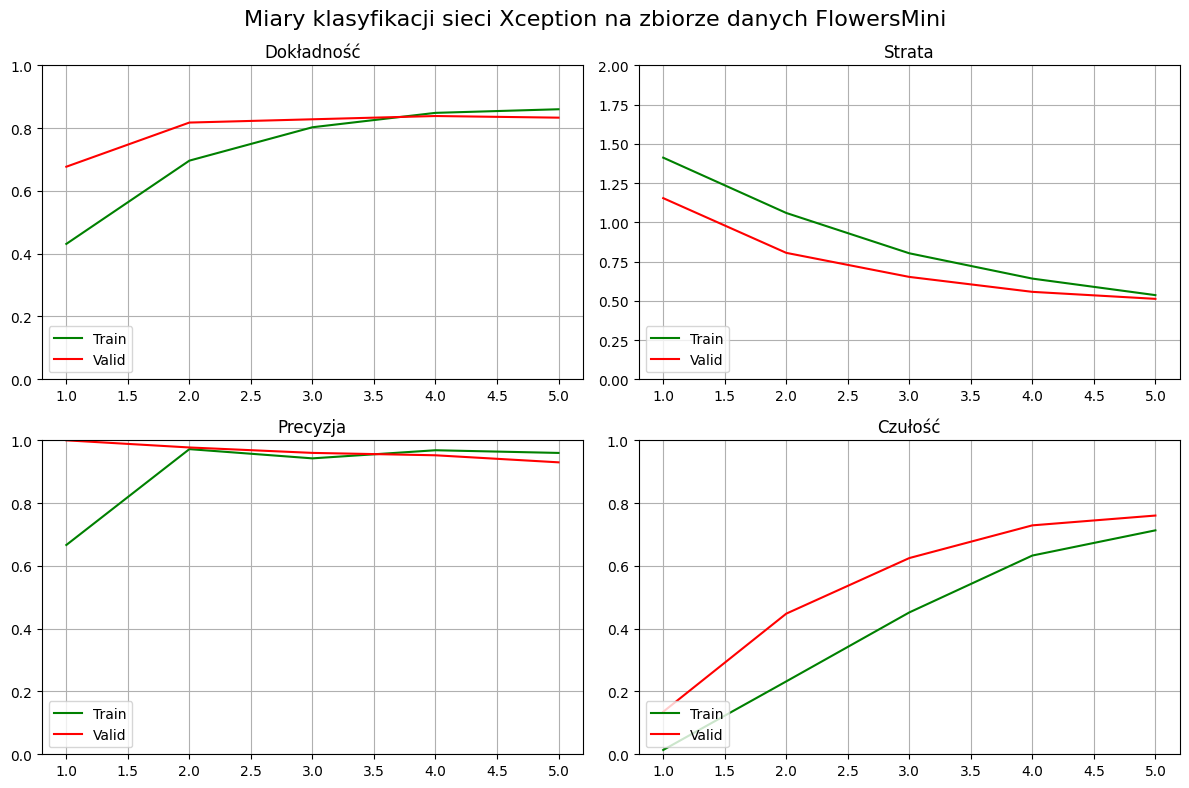


----------    Mobilenet    ----------

Found 500 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Epoch 1/5
7/7 [==============================] - 17s 2s/step - loss: 1.7930 - accuracy: 0.2729 - precision_24: 0.2968 - recall_24: 0.1055 - val_loss: 1.2640 - val_accuracy: 0.4583 - val_precision_24: 0.6818 - val_recall_24: 0.2344
Epoch 2/5
7/7 [==============================] - 9s 1s/step - loss: 1.1631 - accuracy: 0.5482 - precision_24: 0.7202 - recall_24: 0.3188 - val_loss: 0.8693 - val_accuracy: 0.6771 - val_precision_24: 0.8103 - val_recall_24: 0.4896
Epoch 3/5
7/7 [==============================] - 11s 2s/step - loss: 0.8631 - accuracy: 0.6763 - precision_24: 0.8053 - recall_24: 0.5446 - val_loss: 0.6493 - val_accuracy: 0.7552 - val_precision_24: 0.8741 - val_recall_24: 0.6510
Epoch 4/5
7/7 [==============================] - 10s 1s/step - loss: 0.6434 - accuracy: 0.7592 - precision_24: 0.8517 - recall_24: 0.6720 - val_l

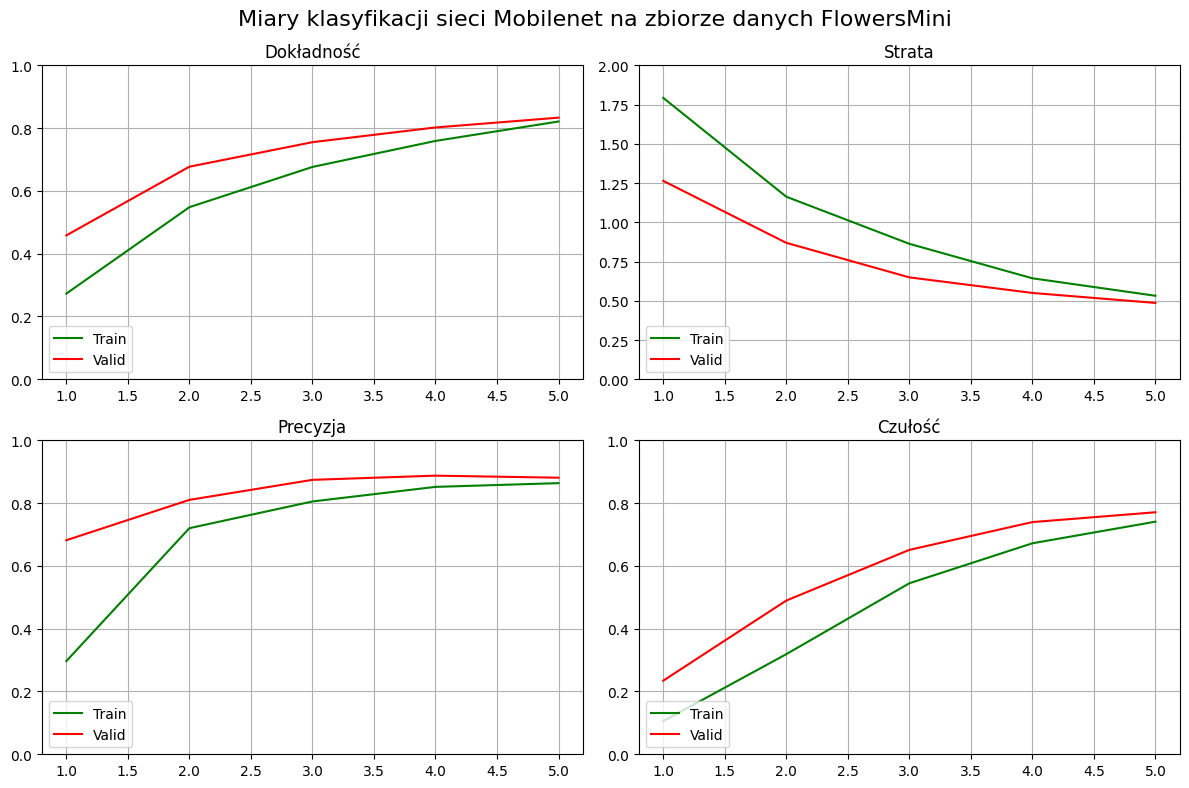


----------    DenseNet169    ----------

Found 500 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Epoch 1/5
7/7 [==============================] - 29s 2s/step - loss: 1.7037 - accuracy: 0.2821 - precision_25: 0.3023 - recall_25: 0.0894 - val_loss: 1.1564 - val_accuracy: 0.5833 - val_precision_25: 0.8421 - val_recall_25: 0.2500
Epoch 2/5
7/7 [==============================] - 11s 2s/step - loss: 1.1748 - accuracy: 0.5550 - precision_25: 0.6776 - recall_25: 0.2844 - val_loss: 0.8276 - val_accuracy: 0.7552 - val_precision_25: 0.8957 - val_recall_25: 0.5365
Epoch 3/5
7/7 [==============================] - 11s 2s/step - loss: 0.9353 - accuracy: 0.6514 - precision_25: 0.7960 - recall_25: 0.4564 - val_loss: 0.5879 - val_accuracy: 0.8177 - val_precision_25: 0.9296 - val_recall_25: 0.6875
Epoch 4/5
7/7 [==============================] - 11s 2s/step - loss: 0.7569 - accuracy: 0.7569 - precision_25: 0.8400 - recall_25: 0.5780 - va

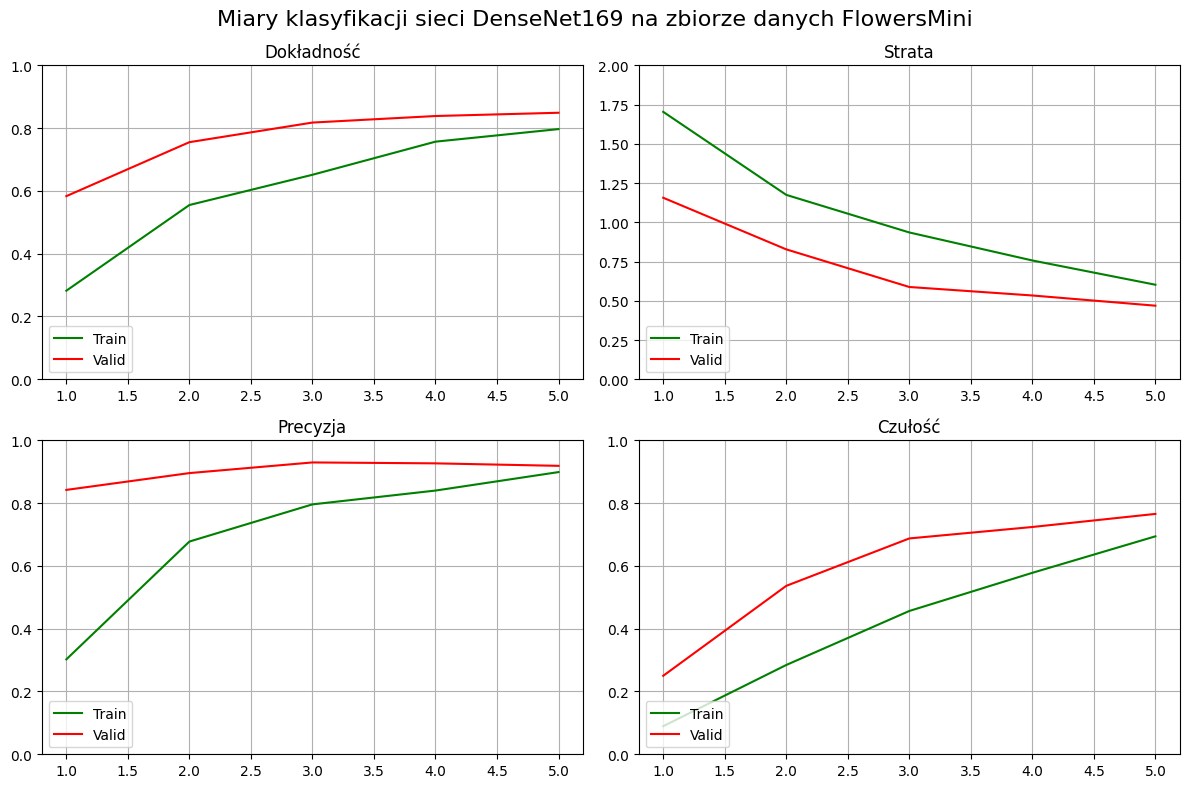


----------    EfficientNetV2B0    ----------

Found 500 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Epoch 1/5
7/7 [==============================] - 24s 2s/step - loss: 1.5074 - accuracy: 0.3417 - precision_26: 0.5294 - recall_26: 0.0206 - val_loss: 1.1971 - val_accuracy: 0.5521 - val_precision_26: 1.0000 - val_recall_26: 0.2344
Epoch 2/5
7/7 [==============================] - 11s 2s/step - loss: 1.1226 - accuracy: 0.6049 - precision_26: 0.8938 - recall_26: 0.2254 - val_loss: 0.8901 - val_accuracy: 0.7396 - val_precision_26: 0.9518 - val_recall_26: 0.4115
Epoch 3/5
7/7 [==============================] - 11s 2s/step - loss: 0.8044 - accuracy: 0.7752 - precision_26: 0.9157 - recall_26: 0.5229 - val_loss: 0.6989 - val_accuracy: 0.8021 - val_precision_26: 0.9640 - val_recall_26: 0.5573
Epoch 4/5
7/7 [==============================] - 11s 2s/step - loss: 0.6681 - accuracy: 0.7982 - precision_26: 0.9172 - recall_26: 0.6353

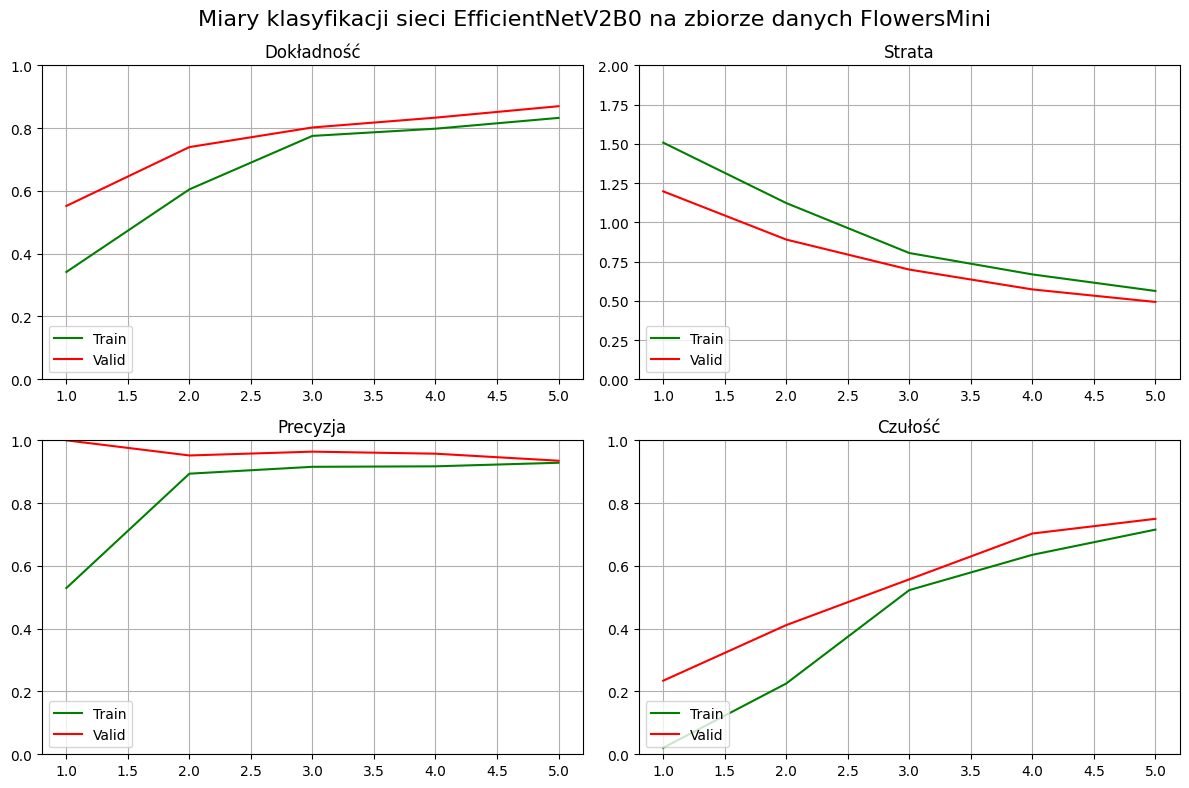

############################################
Całe porównanie zajęło: 9.12 minut 

['Trenowanie modelu Xception na zbiorze danych FlowersMini zajęło 1.72 minut \n', 'Trenowanie modelu Mobilenet na zbiorze danych FlowersMini zajęło 1.26 minut \n', 'Trenowanie modelu DenseNet169 na zbiorze danych FlowersMini zajęło 1.72 minut \n', 'Trenowanie modelu EfficientNetV2B0 na zbiorze danych FlowersMini zajęło 1.62 minut \n', 'Całe porównanie zajęło: 9.12 minut \n']


In [52]:
comparision(DATASETS_INFO, MODELS_INFO)